# External libraries 

> ### In this tutorial we will cover:
> - which file formats are supported
> - how to convert between them
> - what external integrations are available

## Supported formats

BuildAMol Molecules can be loaded from a number of different input types and exported to them as well.
Here is an overview of supported formats:

```mermaid
flowchart TB

  node_1("Molecule")
  node_2(["PDB"])
  node_3(["mmCIF"])
  node_9(["Molfile"])
  node_11(("SMILES"))
  node_4(["JSON\n(BuildAMol)"])
  node_13(["XML\n(BuildAMol)"])
  node_5(["pickle\n(BuildAMol)"])
  node_6{{"rdkit\n(Chem.rdchem.Mol)"}}
  node_7{{"openbabel\n(pybel.Molecule)"}}
  node_8{{"biopython\n(PDB.Structure)"}}
  node_10{{"openmm\n(openmm.PDBFile)"}}
  node_12{{"stk\n(stk.BuildingBlock)"}}
  node_2 <--> node_1
  node_3 <--> node_1
  node_9 <-.-> node_1
  node_11 <-.-> node_1
  node_13 <--> node_1
  node_4 <--> node_1
  node_5 <--> node_1
  node_6 <--> node_1
  node_7 <--> node_1
  node_8 <--> node_1
  node_10 <--> node_1
  node_12 <--> node_1
```

Here are is a table with the corresponding methods available in the `Molecule` class:

| Format    | As input      | As output      |
| --------- | ------------- | -------------- |
| PDB       | `from_pdb`    | `to_pdb`       |
| mmCIF     | `from_cif`    | `to_cif`       |
| Molfile   | `from_molfile` | `to_molfile`  |
| SMILES    | `from_smiles`  | `to_smiles`   |
| JSON      | `from_json`   | `to_json`      |
| XML       | `from_xml`    | `to_xml`       |
| pickle    | `load`        | `save`         |
| rdkit     | `from_rdkit`  | `to_rdkit`     |
| openbabel | `from_pybel`  | `to_pybel`     |
| openmm    | `from_openmm` | `to_openmm`    |
| stk       | `from_stk`    | `to_stk`       |
| biopython | `<normal init>` | `to_biopython` |

In fact, using the toplevel `molecule` function will automatically try to discern which input type is given and perform the necessary file-reading, parsing, and/or format conversions. For some of the methods there are also functional equivalents available such as the `read_pdb` and `write_pdb` functions as equivalents to the `from_pdb` and `to_pdb` methods.

### Example - Converting File Formats

Assuming we want to read a structure from a PDB file, relabel the atoms and save the structure to a CIF file, we could do:

In [1]:
import buildamol as bam

In [ ]:
man = bam.Molecule.from_pdb("files/man.pdb")

# relabel the atoms to match the CHARMM force field nomenclature
man.autolabel()

# save as a CIF file
man.to_cif("files/man.cif")

### Example - Analysing a Molecule in RDKit

BuildAMol is built on top of `biopython` so naturally all BuildAMol molecules can function with `biopython` out of the box. In case any functionality is not working, the extra BuildAMol-overhead can be removed using the `to_biopython` method. However, BuildAMol is not limited to biopython. It also supports direct conversions with `RDKit` and `openbabel`.

So maybe we want to perform some more intricate chemical analyses using `rdkit` but first we want to make use of BuildAMol's easy methods for creating larger molecules. Maybe we want to generate a tri-peptide HIS-GLU-HIS which we can then analyse further.

In [4]:
# first we need to load the amino acids data
bam.load_amino_acids()

# now we get the amino acids we want to connect
his = bam.Molecule.from_compound("HIS")
glu = bam.Molecule.from_compound("GLU")

# connect the amino acids using the peptide linkage (called "LINK")
peptide = his % "LINK" + glu + his
peptide.py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

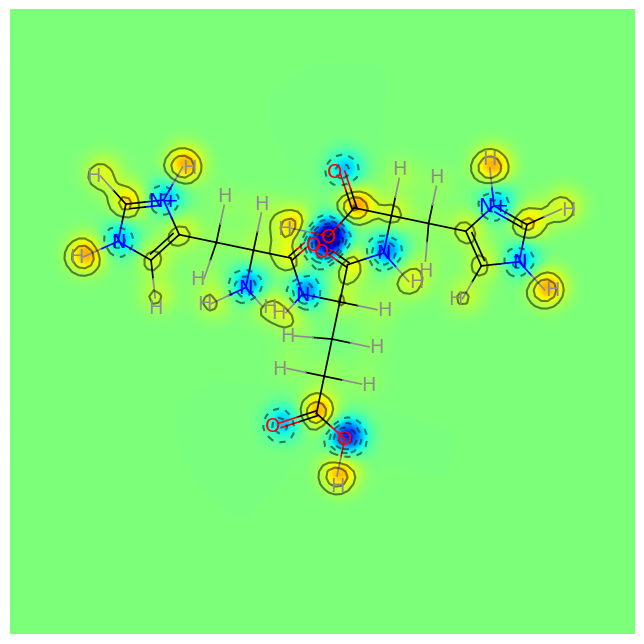

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem

# convert to an RDKit molecule
peptide = peptide.to_rdkit()

# remove the 3D coordinates
peptide.RemoveAllConformers()

# now we can use RDKit to perform further analysis
AllChem.ComputeGasteigerCharges(peptide)
fig = SimilarityMaps.GetSimilarityMapFromWeights(peptide, [x.GetDoubleProp("_GasteigerCharge") for x in peptide.GetAtoms()], colorMap='jet', contourLines=10)


# Example - Importing from Stk

The `Stk` library offers some neat features for making technical molecules such as polymers or molecular cages. Let's say we want to make use of Stk's features and combine it with BuildAMol's flexibility:

In [8]:
import stk

# make the building blocks
bb1 = stk.BuildingBlock('BrCCBr', [stk.BromoFactory()])
bb2 = stk.BuildingBlock('BrCC(CBr)CBr', [stk.BromoFactory()])

# make the COF
cof = stk.ConstructedMolecule(
    topology_graph=stk.cof.Honeycomb(
        building_blocks=(bb1, bb2),
        lattice_size=(3, 3, 1),
        optimizer=stk.Collapser(scale_steps=False),
    ),
)

<ConstructedMolecule at 5252354256>

Now we can import the COF into BuildAMol in order to modify some parts

In [9]:
mol = bam.Molecule.from_stk(cof)

# now add a benzene ring to all branch-points (i.e. carbons with three carbon neighbors)
targets = mol.search_by_constraints(
    [
        bam.structural.neighbors.constraints.has_neighbor_hist({"C": 3})
    ]
)
targets = [i[0] for i in targets]

# add the benzene rings
bam.benzylate(mol, at_atom=targets)

# now look at the molecule
mol.py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And there we have a modified version of the Stk-generated COF! 

And that's it for this tutorial. Thanks for checking it out and good luck with your project using BuildAMol!